## WEEK 4 tf idf example/ PBA 2025
Sentiment Analysis on IMDB dataset



#### Sentiment Analysis on IMDB dataset using different classifiers such as LinearSVM, LogisticRegression, NaiveBayes, XGBoost, RandomForest with different kind of embeddings such as TF-IDF, USE, and TF-IDF+USE

link IMDB dataset: PBA Gasal 2025
https://drive.google.com/drive/folders/1kDZ25BrcPyNGzyrXApu_MRiY4AM-lRYs?usp=sharing

#### Installing and importing libraries

In [1]:
pip install -U nltk

In [2]:
#pip install tensorflow

In [3]:
pip install tensorflow_hub

In [4]:
#pip install torch

In [5]:
#pip install xgboost

In [6]:
import pandas as pd
import numpy as np
import nltk
import re
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [7]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
stop_words = set(stopwords.words('indonesian'))

#### To check is there any GPU available or not

In [10]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")


GPU is available


#### Load the IMDB dataset for sentiment analysis between positive and negative reviews

In [11]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

file_path = "/content/drive/MyDrive/PBA/okejek_with_tokens.csv"

df = pd.read_csv(file_path)
df = df[["content", "sentiment_rating"]]

Mounted at /content/drive


In [12]:
df = df.sample(frac=1).reset_index(drop=True)
df

,content,sentiment_rating
0,sistem chat baik bondowoso hadir sukowono jember,Positive
1,jack kotamobagu banyak drivernya,Positive
2,NaN,Positive
3,mudah mudah jack jaya,Positive
4,bneran,Neutral
...,...,...
4537,lokasi masalah,Negative
4538,aplikasi blom,Negative
4539,dulh nampak drivernga kayak apl belah gak namp...,Negative
4540,promosi tv media digital,Positive


#### Exploratory Data Analysis for IMDB dataset

In [13]:
class EDA():
    def get_length_dist(self,data):
        rev_len = [len(i) for i in data]
        pd.Series(rev_len).hist()
        plt.title('Number of types of commets')
        plt.xlabel('length')
        plt.ylabel('number')
        plt.show()
        print(pd.Series(rev_len).describe())
    def get_class_dist(self,df):
        df['sentiment_rating'].replace({2:'Neutral',1:'Positive',0:'Negative'}).value_counts().plot(kind='bar',figsize=(7,4))
        plt.title('Number of types')
        plt.xlabel('Comment_type')
        plt.ylabel('number')
        plt.show()


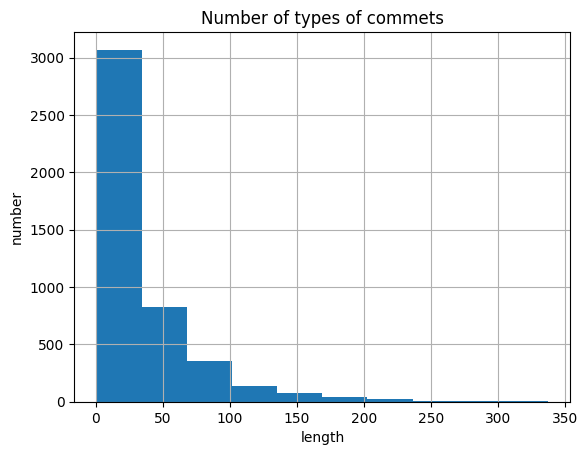

count    4542.000000
mean       34.298107
std        41.220016
min         1.000000
25%         7.000000
50%        19.000000
75%        46.000000
max       337.000000
dtype: float64


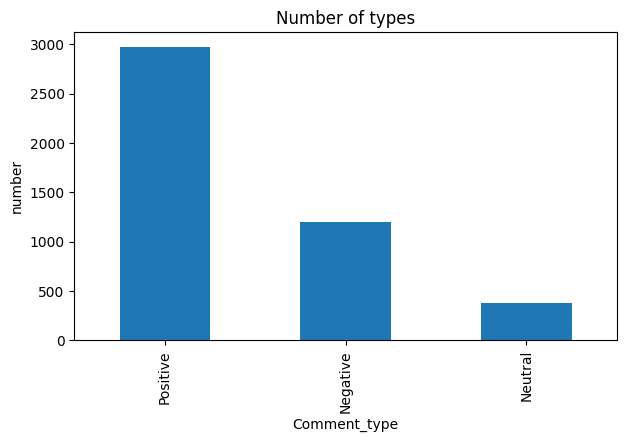

In [14]:
eda = EDA()
eda.get_length_dist(df['content'].astype(str))
eda.get_class_dist(df)

#### Preprocess the data

In [15]:
def preprocess_text(text):
    # Remove HTML tags and strip whitespace
    text = re.sub(r'<[^>]*>', '', text)
    text = text.strip()
    # Remove noisy characters and extra spaces
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # Lowercase text
    text = text.lower()
    # Tokenize text and remove stopwords
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


In [16]:
df['content'] = df['content'].astype(str).apply(preprocess_text)

In [17]:
df['content'].head(20)

,content
0,sistem chat bondowoso hadir sukowono jember
1,jack kotamobagu drivernya
2,nan
3,mudah mudah jack jaya
4,bneran
5,login bisamending aplikasi anterin gampang ga ...
6,coba daerah jakarta drivernya bom
7,jekok food udh adaok massage tunggu lho
8,habis update eror
9,nan


#### Split x=feature, y=target

In [18]:
x = df['content']
y = df['sentiment_rating']

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encode = LabelEncoder()
Y = label_encode.fit_transform(df['sentiment_rating'])
Y

array([2, 2, 2, ..., 0, 2, 1])

In [20]:
y

,sentiment_rating
0,Positive
1,Positive
2,Positive
3,Positive
4,Neutral
...,...
4537,Negative
4538,Negative
4539,Negative
4540,Positive


### Note: 0 represent negative comments and 1 represent positive comments

### Split the dataset into training and testing sets


In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(x, Y, test_size=0.2, random_state=42)

### Create a vocabulary

In [22]:
# Create a vocabulary
from collections import Counter
word_counts = Counter(' '.join(xtrain).split())

### Display each word in the vocabulary along with its count


In [23]:
#for word, count in word_counts.items():
    #print(f"{word}: {count}")

In [24]:
#vocab = [word for word, count in word_counts.most_common()]
#vocab

### Classification with various classifiers
#### 1. Linear SVM
#### 2. Logistic Regression (LR)
#### 3. Naive Bayes
#### 4. XGBoost
#### 5. Random Forest

In [25]:
#Import libraries
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from timeit import default_timer as timer

#### Initialize classifiers

In [26]:
svm_classifier = LinearSVC()
logistic_regression = LogisticRegression(max_iter=1000)
nb_classifier = MultinomialNB()
xgboost_classifier = XGBClassifier()
random_forest_classifier = RandomForestClassifier(n_estimators=100, max_depth=3, max_features='sqrt', min_samples_leaf=4, bootstrap=True, n_jobs=-1, random_state=0)

In [46]:
def evaluate_model(model, xtest, ytest):
    # Make predictions using the model
    y_pred = model.predict(xtest)

    # Calculate accuracy
    accuracy = accuracy_score(ytest, y_pred)
    # Calculate precision
    precision = precision_score(ytest, y_pred, average="macro")
    # Calculate recall
    recall = recall_score(ytest, y_pred, average="macro")
    # Calculate f1 score
    f1 = f1_score(ytest, y_pred, average="macro")
    # Generate a classification report and confusion matrix
    report = classification_report(ytest, y_pred)
    cm = confusion_matrix(ytest, y_pred)
    return y_pred, accuracy, precision, recall, f1, report, cm


In [38]:
# Define batch size
batch_size = 1000

## 1. TF-IDF

#### TF-IDF Vectorization


In [39]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectorizer_xtrain = tfidf_vectorizer.fit_transform(xtrain)
tfidf_vectorizer_xtest = tfidf_vectorizer.transform(xtest)


##### Process the data in smaller batches for training data


In [30]:
# start = timer()
# tfidf_vectorizer_xtrain = []
# for i in range(0, len(xtrain), batch_size):
#     batch_X_train = xtrain[i:i + batch_size]
#     batch_X_train_tfidf = tfidf_vectorizer.fit_transform(batch_X_train)
#     tfidf_vectorizer_xtrain.extend(batch_X_train_tfidf.toarray())
# print('Required time for embedding TFIDF with train data:- ', timer() - start)

Required time for embedding TFIDF with train data:-  0.058533917999966434


##### Repeat the same process for test data


In [31]:
# start = timer()
# tfidf_vectorizer_xtest = []
# for i in range(0, len(xtest), batch_size):
#     batch_X_test = xtest[i:i + batch_size]
#     batch_X_test_tfidf = tfidf_vectorizer.transform(batch_X_test)
#     tfidf_vectorizer_xtest.extend(batch_X_test_tfidf.toarray())
# print('Required time for embedding TFIDF with train data:- ', timer() - start)

Required time for embedding TFIDF with train data:-  0.012701836000019284


In [40]:
print(type(tfidf_vectorizer_xtrain))
print(tfidf_vectorizer_xtrain.shape)

print(type(ytrain))
print(ytrain.shape)
print(ytrain[:10])

<class 'scipy.sparse._csr.csr_matrix'>
(3633, 4059)
<class 'numpy.ndarray'>
(3633,)
[2 0 2 2 2 2 1 0 0 2]


#### Fit classifiers

In [41]:
start = timer()
svm_tfidf = svm_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
print('Training time SVM:', timer() - start)

start = timer()
lr_tfidf = logistic_regression.fit(tfidf_vectorizer_xtrain, ytrain)
print('Training time Logistic Regression:', timer() - start)

start = timer()
nb_tfidf = nb_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
print('Training time Naive Bayes:', timer() - start)

start = timer()
xgboost_tfidf = xgboost_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
print('Training time XGBoost:', timer() - start)

start = timer()
rfc_tfidf = random_forest_classifier.fit(tfidf_vectorizer_xtrain, ytrain)
print('Training time Random Forest:', timer() - start)

Training time SVM: 0.03689994899991689
Training time Logistic Regression: 0.8499875129999737
Training time Naive Bayes: 0.0050469200000407
Training time XGBoost: 2.465993835000063
Training time Random Forest: 0.19829541500007508


#### Make predictions

### Linear SVM

In [47]:
start = timer()
y_pred_svm, accuracy_svm, precision_svm, recall_svm, f1_svm, report_svm, confusion_matrix_svm = evaluate_model(svm_tfidf, tfidf_vectorizer_xtest, ytest)
print('Required time for SVM prediction:- ', timer() - start)

Required time for SVM prediction:-  0.014468701000055262


#### Print actual vs. predicted results for LinearSVM

In [48]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_svm[:15]):
    print(f"Actual: {actual}, SVM Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, SVM Predicted: 0

Actual: 2, SVM Predicted: 2

Actual: 2, SVM Predicted: 2

Actual: 0, SVM Predicted: 0

Actual: 1, SVM Predicted: 0

Actual: 2, SVM Predicted: 2

Actual: 1, SVM Predicted: 0

Actual: 0, SVM Predicted: 0

Actual: 0, SVM Predicted: 0

Actual: 2, SVM Predicted: 2

Actual: 2, SVM Predicted: 2

Actual: 1, SVM Predicted: 0

Actual: 0, SVM Predicted: 0

Actual: 0, SVM Predicted: 2

Actual: 0, SVM Predicted: 0



In [49]:
print(f"LinearSVM Accuracy: {accuracy_svm:.2f}")
print(f"LinearSVM Precision: {precision_svm:.2f}")
print(f"LinearSVM Recall: {recall_svm:.2f}")
print(f"LinearSVM F1 score: {f1_svm:.2f}")
print("Classification Report:")
print(report_svm)
print("Confusion Matrix")
print(confusion_matrix_svm)

LinearSVM Accuracy: 0.79
LinearSVM Precision: 0.57
LinearSVM Recall: 0.56
LinearSVM F1 score: 0.56
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       258
           1       0.17      0.06      0.09        77
           2       0.85      0.93      0.89       574

    accuracy                           0.79       909
   macro avg       0.57      0.56      0.56       909
weighted avg       0.75      0.79      0.77       909

Confusion Matrix
[[180  19  59]
 [ 37   5  35]
 [ 37   6 531]]


### Logistic Regression

In [50]:
start = timer()
y_pred_lr, accuracy_lr, precision_lr, recall_lr, f1_lr, report_lr, cm_lr = evaluate_model(lr_tfidf, tfidf_vectorizer_xtest, ytest)
print('Required time for Logistic Regression prediction:- ', timer() - start)

Required time for Logistic Regression prediction:-  0.023450054000022647


#### Print actual vs. predicted results for Logistic Regression


In [51]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_lr[:15]):
    print(f"Actual: {actual}, Logistic Regression Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, Logistic Regression Predicted: 0

Actual: 2, Logistic Regression Predicted: 2

Actual: 2, Logistic Regression Predicted: 2

Actual: 0, Logistic Regression Predicted: 0

Actual: 1, Logistic Regression Predicted: 0

Actual: 2, Logistic Regression Predicted: 2

Actual: 1, Logistic Regression Predicted: 0

Actual: 0, Logistic Regression Predicted: 0

Actual: 0, Logistic Regression Predicted: 0

Actual: 2, Logistic Regression Predicted: 2

Actual: 2, Logistic Regression Predicted: 2

Actual: 1, Logistic Regression Predicted: 0

Actual: 0, Logistic Regression Predicted: 0

Actual: 0, Logistic Regression Predicted: 2

Actual: 0, Logistic Regression Predicted: 0



In [52]:
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")
print(f"Logistic Regression Precision: {precision_lr:.2f}")
print(f"Logistic Regression Recall: {recall_lr:.2f}")
print(f"Logistic Regression F1 score: {f1_lr:.2f}")
print("Classification Report:")
print(report_lr)
print("Confusion Matrix")
print(cm_lr)

Logistic Regression Accuracy: 0.81
Logistic Regression Precision: 0.53
Logistic Regression Recall: 0.56
Logistic Regression F1 score: 0.54
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       258
           1       0.00      0.00      0.00        77
           2       0.84      0.95      0.89       574

    accuracy                           0.81       909
   macro avg       0.53      0.56      0.54       909
weighted avg       0.74      0.81      0.77       909

Confusion Matrix
[[188   3  67]
 [ 38   0  39]
 [ 27   2 545]]


### Naive bayes

In [53]:
start = timer()
y_pred_nb, accuracy_nb, precision_nb, recall_nb, f1_nb, report_nb, cm_nb = evaluate_model(nb_tfidf, tfidf_vectorizer_xtest, ytest)
print('Required time for Naive Bayes prediction:- ', timer() - start)

Required time for Naive Bayes prediction:-  0.014722640000059073


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

#### Print actual vs. predicted results for Naive bayes


In [54]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_nb[:15]):
    print(f"Actual: {actual}, Naive bayes Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, Naive bayes Predicted: 0

Actual: 2, Naive bayes Predicted: 2

Actual: 2, Naive bayes Predicted: 2

Actual: 0, Naive bayes Predicted: 0

Actual: 1, Naive bayes Predicted: 2

Actual: 2, Naive bayes Predicted: 2

Actual: 1, Naive bayes Predicted: 0

Actual: 0, Naive bayes Predicted: 0

Actual: 0, Naive bayes Predicted: 0

Actual: 2, Naive bayes Predicted: 2

Actual: 2, Naive bayes Predicted: 2

Actual: 1, Naive bayes Predicted: 0

Actual: 0, Naive bayes Predicted: 0

Actual: 0, Naive bayes Predicted: 2

Actual: 0, Naive bayes Predicted: 2



In [55]:
print(f"Naive bayes Accuracy: {accuracy_nb:.2f}")
print(f"Naive bayes Precision: {precision_nb:.2f}")
print(f"Naive bayes Recall: {recall_nb:.2f}")
print(f"Naive bayes F1 score: {f1_nb:.2f}")
print("Classification Report:")
print(report_nb)
print("Confusion Matrix:")
print(cm_nb)

Naive bayes Accuracy: 0.79
Naive bayes Precision: 0.53
Naive bayes Recall: 0.53
Naive bayes F1 score: 0.52
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.63      0.70       258
           1       0.00      0.00      0.00        77
           2       0.79      0.97      0.87       574

    accuracy                           0.79       909
   macro avg       0.53      0.53      0.52       909
weighted avg       0.72      0.79      0.75       909

Confusion Matrix:
[[162   0  96]
 [ 25   0  52]
 [ 18   0 556]]


### XGBoost Classifier

In [56]:
start = timer()
y_pred_xgboost, accuracy_xgboost, precision_xgboost, recall_xgboost, f1_xgboost, report_xgboost, cm_xgboost = evaluate_model(xgboost_tfidf, tfidf_vectorizer_xtest, ytest)
print('Required time for XGBoost classifier prediction:- ', timer() - start)

Required time for XGBoost classifier prediction:-  0.04133449300002212


#### Print actual vs. predicted results for XGBoost classifier


In [57]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_xgboost[:15]):
    print(f"Actual: {actual}, XGBoost Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, XGBoost Predicted: 0

Actual: 2, XGBoost Predicted: 2

Actual: 2, XGBoost Predicted: 2

Actual: 0, XGBoost Predicted: 0

Actual: 1, XGBoost Predicted: 2

Actual: 2, XGBoost Predicted: 2

Actual: 1, XGBoost Predicted: 0

Actual: 0, XGBoost Predicted: 0

Actual: 0, XGBoost Predicted: 0

Actual: 2, XGBoost Predicted: 2

Actual: 2, XGBoost Predicted: 2

Actual: 1, XGBoost Predicted: 0

Actual: 0, XGBoost Predicted: 0

Actual: 0, XGBoost Predicted: 2

Actual: 0, XGBoost Predicted: 2



In [58]:
print(f"XGBoost Accuracy: {accuracy_xgboost:.2f}")
print(f"XGBoost Precision: {precision_xgboost:.2f}")
print(f"XGBoost Recall: {recall_xgboost:.2f}")
print(f"XGBoost F1 score: {f1_xgboost:.2f}")
print("Classification Report:")
print(report_xgboost)
print("Confusion Matrix:")
print(cm_xgboost)

XGBoost Accuracy: 0.80
XGBoost Precision: 0.62
XGBoost Recall: 0.57
XGBoost F1 score: 0.57
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       258
           1       0.30      0.08      0.12        77
           2       0.84      0.94      0.89       574

    accuracy                           0.80       909
   macro avg       0.62      0.57      0.57       909
weighted avg       0.76      0.80      0.77       909

Confusion Matrix:
[[179   9  70]
 [ 35   6  36]
 [ 29   5 540]]


### Random Forest Classifier

In [59]:
start = timer()
y_pred_rfc, accuracy_rfc, precision_rfc, recall_rfc, f1_rfc, report_rfc, cm_rfc = evaluate_model(rfc_tfidf, tfidf_vectorizer_xtest, ytest)
print('Required time for Random Forest classifier prediction:- ', timer() - start)

Required time for Random Forest classifier prediction:-  0.0476948129999073


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

#### Print actual vs. predicted results for Random Forest classifier

In [60]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_rfc[:15]):
    print(f"Actual: {actual}, Random Forest Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, Random Forest Predicted: 2

Actual: 2, Random Forest Predicted: 2

Actual: 2, Random Forest Predicted: 2

Actual: 0, Random Forest Predicted: 2

Actual: 1, Random Forest Predicted: 2

Actual: 2, Random Forest Predicted: 2

Actual: 1, Random Forest Predicted: 2

Actual: 0, Random Forest Predicted: 2

Actual: 0, Random Forest Predicted: 2

Actual: 2, Random Forest Predicted: 2

Actual: 2, Random Forest Predicted: 2

Actual: 1, Random Forest Predicted: 2

Actual: 0, Random Forest Predicted: 2

Actual: 0, Random Forest Predicted: 2

Actual: 0, Random Forest Predicted: 2



In [61]:
print(f"Random Forest Accuracy: {accuracy_rfc:.2f}")
print(f"Random Forest Precision: {precision_rfc:.2f}")
print(f"Random Forest Recall: {recall_rfc:.2f}")
print(f"Random Forest F1 score: {f1_rfc:.2f}")
print("Classification Report:")
print(report_rfc)
print("Confusion Matrix:")
print(cm_rfc)

Random Forest Accuracy: 0.63
Random Forest Precision: 0.21
Random Forest Recall: 0.33
Random Forest F1 score: 0.26
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       258
           1       0.00      0.00      0.00        77
           2       0.63      1.00      0.77       574

    accuracy                           0.63       909
   macro avg       0.21      0.33      0.26       909
weighted avg       0.40      0.63      0.49       909

Confusion Matrix:
[[  0   0 258]
 [  0   0  77]
 [  0   0 574]]


#### Display all five models accuracy

In [62]:
model_names = ['LinearSVM', 'LogisticRegression', 'NaiveBayes', 'XGBoost', 'RandomForest']
model_accuracies = [accuracy_svm, accuracy_lr, accuracy_nb, accuracy_xgboost, accuracy_rfc]

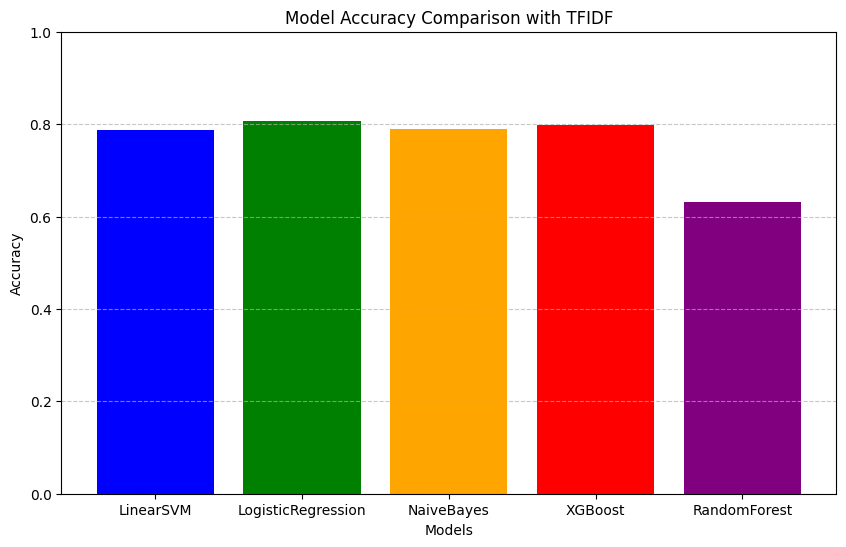

In [63]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison with TFIDF")
plt.ylim(0.0, 1.0)  # Set the y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 2. Universal Sentence Encoder (USE)
#### 1. Linear SVM
#### 2. Logistic Regression
#### 3. XGBoost classifier
#### 4. Random Forest classifier

#### Load the Universal Sentence Encoder model, and embed this model

In [64]:
start = timer()
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
print('Required time for upload USE from tensorflow hub:- ', timer() - start)

Required time for upload USE from tensorflow hub:-  22.495054390000064


In [65]:
xtrain_use = []
xtest_use = []

In [66]:
start = timer()
for i in range(0, len(xtrain), batch_size):
    batch_X_train = xtrain[i:i + batch_size]
    batch_X_train_use = np.array(embed(batch_X_train))
    xtrain_use.extend(batch_X_train_use)
print('Required time for embedding xtrain with USE:- ', timer() - start)

Required time for embedding xtrain with USE:-  4.502297543000054


In [67]:
start = timer()
for i in range(0, len(xtest), batch_size):
    batch_X_test = xtest[i:i + batch_size]
    batch_X_test_use = np.array(embed(batch_X_test))
    xtest_use.extend(batch_X_test_use)
print('Required time for embedding xtest with USE:- ', timer() - start)

Required time for embedding xtest with USE:-  0.047477509000032114


#### Fit classifiers

In [68]:
start = timer()
svm_use = svm_classifier.fit(xtrain_use, ytrain)
print('Required time for training Linear SVM classifier:- ', timer() - start)
start = timer()
lr_use = logistic_regression.fit(xtrain_use, ytrain)
print('Required time for training Logistic Regression:- ', timer() - start)
start = timer()
xgboost_use = xgboost_classifier.fit(xtrain_use, ytrain)
print('Required time for training XGBoost classifier:- ', timer() - start)
start = timer()
rfc_use = random_forest_classifier.fit(xtrain_use, ytrain)
print('Required time for training all Random Forest classifier:- ', timer() - start)

Required time for training Linear SVM classifier:-  1.528399927999999
Required time for training Logistic Regression:-  0.5594071869999198
Required time for training XGBoost classifier:-  27.99776181699997
Required time for training all Random Forest classifier:-  1.6319982579999532


#### Make predictions

### Linear SVM

In [69]:
start = timer()
y_pred_svm_use, accuracy_svm_use, precision_svm_use, recall_svm_use, f1_svm_use, report_svm_use, cm_svm_use = evaluate_model(svm_use, xtest_use, ytest)
print('Required time for Linear SVM prediction with USE :- ', timer() - start)

Required time for Linear SVM prediction with USE :-  0.020259582000107912


#### Print actual vs. predicted results for LinearSVM with USE

In [70]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_svm_use[:15]):
    print(f"Actual: {actual}, SVM with USE embedding Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, SVM with USE embedding Predicted: 0

Actual: 2, SVM with USE embedding Predicted: 2

Actual: 2, SVM with USE embedding Predicted: 2

Actual: 0, SVM with USE embedding Predicted: 0

Actual: 1, SVM with USE embedding Predicted: 0

Actual: 2, SVM with USE embedding Predicted: 2

Actual: 1, SVM with USE embedding Predicted: 0

Actual: 0, SVM with USE embedding Predicted: 0

Actual: 0, SVM with USE embedding Predicted: 0

Actual: 2, SVM with USE embedding Predicted: 2

Actual: 2, SVM with USE embedding Predicted: 2

Actual: 1, SVM with USE embedding Predicted: 0

Actual: 0, SVM with USE embedding Predicted: 0

Actual: 0, SVM with USE embedding Predicted: 0

Actual: 0, SVM with USE embedding Predicted: 2



In [71]:
print(f"LinearSVM (USE) Accuracy: {accuracy_svm_use:.2f}")
print(f"LinearSVM (USE) Precision: {precision_svm_use:.2f}")
print(f"LinearSVM (USE) Recall: {recall_svm_use:.2f}")
print(f"LinearSVM (USE) F1 score: {f1_svm_use:.2f}")
print("Classification Report:")
print(report_svm_use)
print("Confusion Matrix")
print(cm_svm_use)

LinearSVM (USE) Accuracy: 0.76
LinearSVM (USE) Precision: 0.61
LinearSVM (USE) Recall: 0.54
LinearSVM (USE) F1 score: 0.53
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       258
           1       0.38      0.04      0.07        77
           2       0.81      0.90      0.85       574

    accuracy                           0.76       909
   macro avg       0.61      0.54      0.53       909
weighted avg       0.73      0.76      0.73       909

Confusion Matrix
[[172   4  82]
 [ 33   3  41]
 [ 56   1 517]]


### Logitic Regression

In [72]:
start = timer()
y_pred_lr_use, accuracy_lr_use, precision_lr_use, recall_lr_use, f1_lr_use, report_lr_use, cm_lr_use = evaluate_model(lr_use, xtest_use, ytest)
print('Required time for LR prediction with USE :- ', timer() - start)

Required time for LR prediction with USE :-  0.026254715999925793


#### Print actual vs. predicted results for Logistic Regression with USE

In [73]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_lr_use[:15]):
    print(f"Actual: {actual}, Logistic Regression Predicted with USE: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 2, Logistic Regression Predicted with USE: 2

Actual: 2, Logistic Regression Predicted with USE: 2

Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 1, Logistic Regression Predicted with USE: 2

Actual: 2, Logistic Regression Predicted with USE: 2

Actual: 1, Logistic Regression Predicted with USE: 0

Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 0, Logistic Regression Predicted with USE: 2

Actual: 2, Logistic Regression Predicted with USE: 2

Actual: 2, Logistic Regression Predicted with USE: 2

Actual: 1, Logistic Regression Predicted with USE: 0

Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 0, Logistic Regression Predicted with USE: 0

Actual: 0, Logistic Regression Predicted with USE: 2



In [74]:
print(f"Logistic Regression (USE) Accuracy: {accuracy_lr_use:.2f}")
print(f"Logistic Regression (USE) Precision: {precision_lr_use:.2f}")
print(f"Logistic Regression (USE) Recall: {recall_lr_use:.2f}")
print(f"Logistic Regression (USE) F1 score: {f1_lr_use:.2f}")
print("Classification Report:")
print(report_lr_use)
print("Confusion Matrix")
print(cm_lr_use)

Logistic Regression (USE) Accuracy: 0.76
Logistic Regression (USE) Precision: 0.49
Logistic Regression (USE) Recall: 0.52
Logistic Regression (USE) F1 score: 0.50
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       258
           1       0.00      0.00      0.00        77
           2       0.80      0.91      0.85       574

    accuracy                           0.76       909
   macro avg       0.49      0.52      0.50       909
weighted avg       0.69      0.76      0.72       909

Confusion Matrix
[[164   3  91]
 [ 35   0  42]
 [ 50   0 524]]


### XGBoost Classifier

In [75]:
start = timer()
y_pred_xgboost_use, accuracy_xgboost_use, precision_xgboost_use, recall_xgboost_use, f1_xgboost_use, report_xgboost_use, cm_xgboost_use = evaluate_model(xgboost_use, xtest_use, ytest)
print('Required time for XGBoost classifier prediction with USE:- ', timer() - start)

Required time for XGBoost classifier prediction with USE:-  0.032835342999987915


#### Print actual vs. predicted results for XGBooost classifier with USE

In [76]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_xgboost_use[:15]):
    print(f"Actual: {actual}, XGBoost with USE Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, XGBoost with USE Predicted: 0

Actual: 2, XGBoost with USE Predicted: 2

Actual: 2, XGBoost with USE Predicted: 2

Actual: 0, XGBoost with USE Predicted: 0

Actual: 1, XGBoost with USE Predicted: 0

Actual: 2, XGBoost with USE Predicted: 2

Actual: 1, XGBoost with USE Predicted: 2

Actual: 0, XGBoost with USE Predicted: 0

Actual: 0, XGBoost with USE Predicted: 0

Actual: 2, XGBoost with USE Predicted: 2

Actual: 2, XGBoost with USE Predicted: 2

Actual: 1, XGBoost with USE Predicted: 0

Actual: 0, XGBoost with USE Predicted: 0

Actual: 0, XGBoost with USE Predicted: 0

Actual: 0, XGBoost with USE Predicted: 0



In [77]:
print(f"XGBoost (USE) Accuracy: {accuracy_xgboost_use:.2f}")
print(f"XGBoost (USE) Precision: {precision_xgboost_use:.2f}")
print(f"XGBoost (USE) Recall: {recall_xgboost_use:.2f}")
print(f"XGBoost (USE) F1 score: {f1_xgboost_use:.2f}")
print("Classification Report:")
print(report_xgboost_use)
print("Confusion Matrix:")
print(cm_xgboost_use)

XGBoost (USE) Accuracy: 0.76
XGBoost (USE) Precision: 0.54
XGBoost (USE) Recall: 0.52
XGBoost (USE) F1 score: 0.51
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.67       258
           1       0.12      0.01      0.02        77
           2       0.80      0.91      0.85       574

    accuracy                           0.76       909
   macro avg       0.54      0.52      0.51       909
weighted avg       0.71      0.76      0.73       909

Confusion Matrix:
[[167   4  87]
 [ 31   1  45]
 [ 46   3 525]]


### Random Forest Classifier

In [78]:
start = timer()
y_pred_rfc_use, accuracy_rfc_use, precision_rfc_use, recall_rfc_use, f1_rfc_use, report_rfc_use, cm_rfc_use = evaluate_model(rfc_use, xtest_use, ytest)
print('Required time for Random Forest classifier with USE prediction:- ', timer() - start)

Required time for Random Forest classifier with USE prediction:-  0.03864831900000354


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

#### Print actual vs. predicted results for Random Forest classifier with USE

In [79]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_rfc_use[:15]):
    print(f"Actual: {actual}, Random Forest with USE Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, Random Forest with USE Predicted: 0

Actual: 2, Random Forest with USE Predicted: 2

Actual: 2, Random Forest with USE Predicted: 2

Actual: 0, Random Forest with USE Predicted: 0

Actual: 1, Random Forest with USE Predicted: 2

Actual: 2, Random Forest with USE Predicted: 2

Actual: 1, Random Forest with USE Predicted: 0

Actual: 0, Random Forest with USE Predicted: 2

Actual: 0, Random Forest with USE Predicted: 2

Actual: 2, Random Forest with USE Predicted: 2

Actual: 2, Random Forest with USE Predicted: 2

Actual: 1, Random Forest with USE Predicted: 2

Actual: 0, Random Forest with USE Predicted: 2

Actual: 0, Random Forest with USE Predicted: 2

Actual: 0, Random Forest with USE Predicted: 2



In [80]:
print(f"Random Forest (USE) Accuracy: {accuracy_rfc_use:.2f}")
print(f"Random Forest (USE) Precision: {precision_rfc_use:.2f}")
print(f"Random Forest (USE) Recall: {recall_rfc_use:.2f}")
print(f"Random Forest (USE) F1 score: {f1_rfc_use:.2f}")
print("Classification Report:")
print(report_rfc_use)
print("Confusion Matrix:")
print(cm_rfc_use)

Random Forest (USE) Accuracy: 0.69
Random Forest (USE) Precision: 0.46
Random Forest (USE) Recall: 0.42
Random Forest (USE) F1 score: 0.40
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.28      0.40       258
           1       0.00      0.00      0.00        77
           2       0.69      0.96      0.80       574

    accuracy                           0.69       909
   macro avg       0.46      0.42      0.40       909
weighted avg       0.63      0.69      0.62       909

Confusion Matrix:
[[ 73   0 185]
 [ 13   0  64]
 [ 21   0 553]]


#### Display all four models accuracy
##### (--Note: Naive bayes (MultinomialNB) model not used with USE embedding because it not able to resolve the issue of negative values)

In [81]:
model_names = ['LinearSVM', 'LogisticRegression', 'XGBoost', 'RandomForest']
model_accuracies = [accuracy_svm_use, accuracy_lr_use, accuracy_xgboost_use, accuracy_rfc_use]

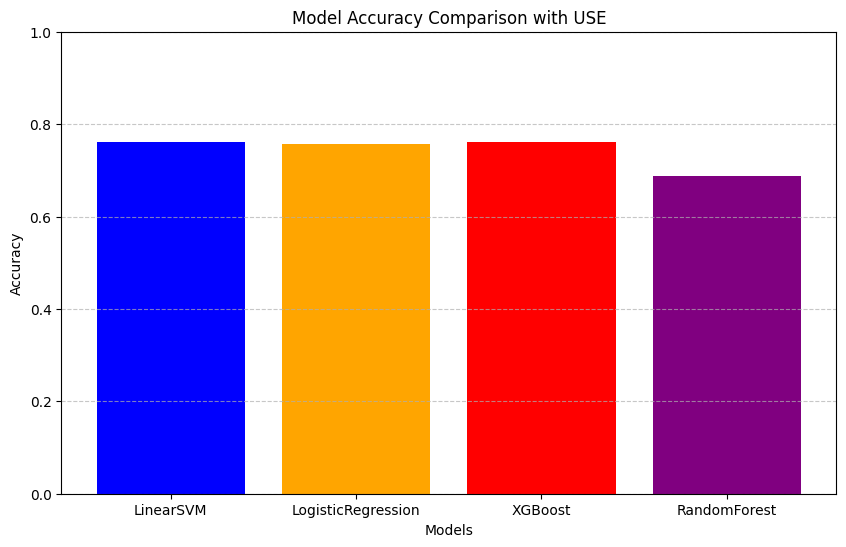

In [82]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color=['blue', 'orange', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison with USE")
plt.ylim(0.0, 1.0)  # Set the y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 3. TF-IDF + Universal Sentence Encoder (USE)
#### 1. Linear SVM
#### 2. Logistic Regression
#### 3. XGBoost classifier
#### 4. Random Forest classifier

#### Combine TF-IDF and Universal Sentence Encoder embeddings


In [86]:
# xtrain_tfidf_use_combined = tf.concat([tfidf_vectorizer_xtrain, xtrain_use], axis=1)
# xtest_tfidf_use_combined = tf.concat([tfidf_vectorizer_xtest, xtest_use], axis=1)

from scipy.sparse import hstack

xtrain_use_np = np.array(xtrain_use)
xtest_use_np = np.array(xtest_use)

xtrain_tfidf_use_combined = hstack([tfidf_vectorizer_xtrain, xtrain_use_np])
xtest_tfidf_use_combined = hstack([tfidf_vectorizer_xtest, xtest_use_np])

#### Fit classifiers

In [87]:
start = timer()
svm_tfidf_use = svm_classifier.fit(xtrain_tfidf_use_combined, ytrain)
print('Required time for training Linear SVM:- ', timer() - start)
start = timer()
lr_tfidf_use = logistic_regression.fit(xtrain_tfidf_use_combined, ytrain)
print('Required time for training Logistic Regression:- ', timer() - start)
start = timer()
xgboost_tfidf_use = xgboost_classifier.fit(xtrain_tfidf_use_combined, ytrain)
print('Required time for training XGBoost classifier:- ', timer() - start)
start = timer()
rfc_tfidf_use = random_forest_classifier.fit(xtrain_tfidf_use_combined, ytrain)
print('Required time for training Random Forest classifier:- ', timer() - start)

Required time for training Linear SVM:-  0.8986110739999731
Required time for training Logistic Regression:-  3.111325459999989
Required time for training XGBoost classifier:-  30.194791183999996
Required time for training Random Forest classifier:-  0.7885609659999773


#### Make predictions

### Linear SVM

In [88]:
start = timer()
y_pred_svm_tfidf_use, accuracy_svm_tfidf_use, precision_svm_tfidf_use, recall_svm_tfidf_use, f1_svm_tfidf_use, report_svm_tfidf_use, cm_svm_tfidf_use = evaluate_model(svm_tfidf_use, xtest_tfidf_use_combined, ytest)
print('Required time for Linear SVM prediction with TFIDF+USE :- ', timer() - start)

Required time for Linear SVM prediction with TFIDF+USE :-  0.016688415000089662


#### Print actual vs. predicted results for Linear SVM with TFIDF + USE

In [89]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_svm_tfidf_use[:15]):
    print(f"Actual: {actual}, SVM with TFIDF+USE Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 2, SVM with TFIDF+USE Predicted: 2

Actual: 2, SVM with TFIDF+USE Predicted: 2

Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 1, SVM with TFIDF+USE Predicted: 0

Actual: 2, SVM with TFIDF+USE Predicted: 2

Actual: 1, SVM with TFIDF+USE Predicted: 0

Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 2, SVM with TFIDF+USE Predicted: 2

Actual: 2, SVM with TFIDF+USE Predicted: 2

Actual: 1, SVM with TFIDF+USE Predicted: 0

Actual: 0, SVM with TFIDF+USE Predicted: 0

Actual: 0, SVM with TFIDF+USE Predicted: 2

Actual: 0, SVM with TFIDF+USE Predicted: 2



In [90]:
print(f"LinearSVM (TFIDF+USE) Accuracy: {accuracy_svm_tfidf_use:.2f}")
print(f"LinearSVM (TFIDF+USE) Precision: {precision_svm_tfidf_use:.2f}")
print(f"LinearSVM (TFIDF+USE) Recall: {recall_svm_tfidf_use:.2f}")
print(f"LinearSVM (TFIDF+USE) F1 score: {f1_svm_tfidf_use:.2f}")
print("Classification Report:")
print(report_svm_tfidf_use)
print("Confusion Matrix")
print(cm_svm_tfidf_use)

LinearSVM (TFIDF+USE) Accuracy: 0.79
LinearSVM (TFIDF+USE) Precision: 0.59
LinearSVM (TFIDF+USE) Recall: 0.57
LinearSVM (TFIDF+USE) F1 score: 0.57
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       258
           1       0.21      0.09      0.13        77
           2       0.85      0.92      0.88       574

    accuracy                           0.79       909
   macro avg       0.59      0.57      0.57       909
weighted avg       0.76      0.79      0.77       909

Confusion Matrix
[[180  18  60]
 [ 35   7  35]
 [ 36   9 529]]


### Logistic Regression

In [91]:
start = timer()
y_pred_lr_tfidf_use, accuracy_lr_tfidf_use, precision_lr_tfidf_use, recall_lr_tfidf_use, f1_lr_tfidf_use, report_lr_tfidf_use, cm_lr_tfidf_use = evaluate_model(lr_tfidf_use, xtest_tfidf_use_combined, ytest)
print('Required time for Logistic Regression prediction with TFIDF+USE :- ', timer() - start)

Required time for Logistic Regression prediction with TFIDF+USE :-  0.02805165500012663


#### Print actual vs. predicted results for Logistic Regression with TFIDF + USE

In [92]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_lr_tfidf_use[:15]):
    print(f"Actual: {actual}, LR with TFIDF+USE embedding Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 2, LR with TFIDF+USE embedding Predicted: 2

Actual: 2, LR with TFIDF+USE embedding Predicted: 2

Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 1, LR with TFIDF+USE embedding Predicted: 0

Actual: 2, LR with TFIDF+USE embedding Predicted: 2

Actual: 1, LR with TFIDF+USE embedding Predicted: 0

Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 2, LR with TFIDF+USE embedding Predicted: 2

Actual: 2, LR with TFIDF+USE embedding Predicted: 2

Actual: 1, LR with TFIDF+USE embedding Predicted: 0

Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 0, LR with TFIDF+USE embedding Predicted: 0

Actual: 0, LR with TFIDF+USE embedding Predicted: 2



In [93]:
print(f"Logistic Regression (TFIDF+USE) Accuracy: {accuracy_lr_tfidf_use:.2f}")
print(f"Logistic Regression (TFIDF+USE) Precision: {precision_lr_tfidf_use:.2f}")
print(f"Logistic Regression (TFIDF+USE) Recall: {recall_lr_tfidf_use:.2f}")
print(f"Logistic Regression (TFIDF+USE) F1 score: {f1_lr_tfidf_use:.2f}")
print("Classification Report:")
print(report_lr_tfidf_use)
print("Confusion Matrix")
print(cm_lr_tfidf_use)

Logistic Regression (TFIDF+USE) Accuracy: 0.81
Logistic Regression (TFIDF+USE) Precision: 0.60
Logistic Regression (TFIDF+USE) Recall: 0.57
Logistic Regression (TFIDF+USE) F1 score: 0.56
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       258
           1       0.22      0.03      0.05        77
           2       0.85      0.94      0.89       574

    accuracy                           0.81       909
   macro avg       0.60      0.57      0.56       909
weighted avg       0.76      0.81      0.78       909

Confusion Matrix
[[193   7  58]
 [ 37   2  38]
 [ 36   0 538]]


### XGBoost Classifier

In [94]:
start = timer()
y_pred_xgb_tfidf_use, accuracy_xgb_tfidf_use, precision_xgb_tfidf_use, recall_xgb_tfidf_use, f1_xgb_tfidf_use, report_xgb_tfidf_use, cm_xgb_tfidf_use = evaluate_model(xgboost_tfidf_use, xtest_tfidf_use_combined, ytest)
print('Required time for XGBoost prediction with TFIDF+USE :- ', timer() - start)

Required time for XGBoost prediction with TFIDF+USE :-  0.038494893000006414


#### Print actual vs. predicted results for XGBoost with TFIDF + USE

In [95]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_xgb_tfidf_use[:15]):
    print(f"Actual: {actual}, XGBoost with TFIDF+USE embedding Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 2, XGBoost with TFIDF+USE embedding Predicted: 2

Actual: 2, XGBoost with TFIDF+USE embedding Predicted: 2

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 2, XGBoost with TFIDF+USE embedding Predicted: 2

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 2

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 2, XGBoost with TFIDF+USE embedding Predicted: 2

Actual: 2, XGBoost with TFIDF+USE embedding Predicted: 2

Actual: 1, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 0

Actual: 0, XGBoost with TFIDF+USE embedding Predicted: 2



In [96]:
print(f"XGBoost (TFIDF+USE) Accuracy: {accuracy_xgb_tfidf_use:.2f}")
print(f"XGBoost (TFIDF+USE) Precision: {precision_xgb_tfidf_use:.2f}")
print(f"XGBoost (TFIDF+USE) Recall: {recall_xgb_tfidf_use:.2f}")
print(f"XGBoost (TFIDF+USE) F1 score: {f1_xgb_tfidf_use:.2f}")
print("Classification Report:")
print(report_xgb_tfidf_use)
print("Confusion Matrix:")
print(cm_xgb_tfidf_use)

XGBoost (TFIDF+USE) Accuracy: 0.79
XGBoost (TFIDF+USE) Precision: 0.56
XGBoost (TFIDF+USE) Recall: 0.55
XGBoost (TFIDF+USE) F1 score: 0.54
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       258
           1       0.14      0.01      0.02        77
           2       0.82      0.93      0.87       574

    accuracy                           0.79       909
   macro avg       0.56      0.55      0.54       909
weighted avg       0.73      0.79      0.75       909

Confusion Matrix:
[[181   2  75]
 [ 32   1  44]
 [ 37   4 533]]


### Random Forest classifier

In [97]:
start = timer()
y_pred_rfc_tfidf_use, accuracy_rfc_tfidf_use, precision_rfc_tfidf_use, recall_rfc_tfidf_use, f1_rfc_tfidf_use, report_rfc_tfidf_use, cm_rfc_tfidf_use = evaluate_model(rfc_tfidf_use, xtest_tfidf_use_combined, ytest)
print('Required time for Random Forest prediction with TFIDF+USE :- ', timer() - start)

Required time for Random Forest prediction with TFIDF+USE :-  0.0742179460000898


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

#### Print actual vs. predicted results for Random Forest with TFIDF + USE

In [98]:
print('0 = negative, 1 = positive')
for actual, predicted in zip(ytest[:15], y_pred_rfc_tfidf_use[:15]):
    print(f"Actual: {actual}, RFC with TFIDF+USE embedding Predicted: {predicted}")
    print()

0 = negative, 1 = positive
Actual: 0, RFC with TFIDF+USE embedding Predicted: 0

Actual: 2, RFC with TFIDF+USE embedding Predicted: 2

Actual: 2, RFC with TFIDF+USE embedding Predicted: 2

Actual: 0, RFC with TFIDF+USE embedding Predicted: 2

Actual: 1, RFC with TFIDF+USE embedding Predicted: 2

Actual: 2, RFC with TFIDF+USE embedding Predicted: 2

Actual: 1, RFC with TFIDF+USE embedding Predicted: 0

Actual: 0, RFC with TFIDF+USE embedding Predicted: 2

Actual: 0, RFC with TFIDF+USE embedding Predicted: 2

Actual: 2, RFC with TFIDF+USE embedding Predicted: 2

Actual: 2, RFC with TFIDF+USE embedding Predicted: 2

Actual: 1, RFC with TFIDF+USE embedding Predicted: 2

Actual: 0, RFC with TFIDF+USE embedding Predicted: 2

Actual: 0, RFC with TFIDF+USE embedding Predicted: 2

Actual: 0, RFC with TFIDF+USE embedding Predicted: 2



In [99]:
print(f"Random Forest (TFIDF+USE) Accuracy: {accuracy_rfc_tfidf_use:.2f}")
print(f"Random Forest (TFIDF+USE) Precision: {precision_rfc_tfidf_use:.2f}")
print(f"Random Forest (TFIDF+USE) Recall: {recall_rfc_tfidf_use:.2f}")
print(f"Random Forest (TFIDF+USE) F1 score: {f1_rfc_tfidf_use:.2f}")
print("Classification Report:")
print(report_rfc_tfidf_use)
print("Confusion Matrix:")
print(cm_rfc_tfidf_use)

Random Forest (TFIDF+USE) Accuracy: 0.66
Random Forest (TFIDF+USE) Precision: 0.45
Random Forest (TFIDF+USE) Recall: 0.37
Random Forest (TFIDF+USE) F1 score: 0.33
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.11      0.19       258
           1       0.00      0.00      0.00        77
           2       0.66      0.99      0.79       574

    accuracy                           0.66       909
   macro avg       0.45      0.37      0.33       909
weighted avg       0.61      0.66      0.55       909

Confusion Matrix:
[[ 28   0 230]
 [  9   0  68]
 [  4   0 570]]


### Visualization

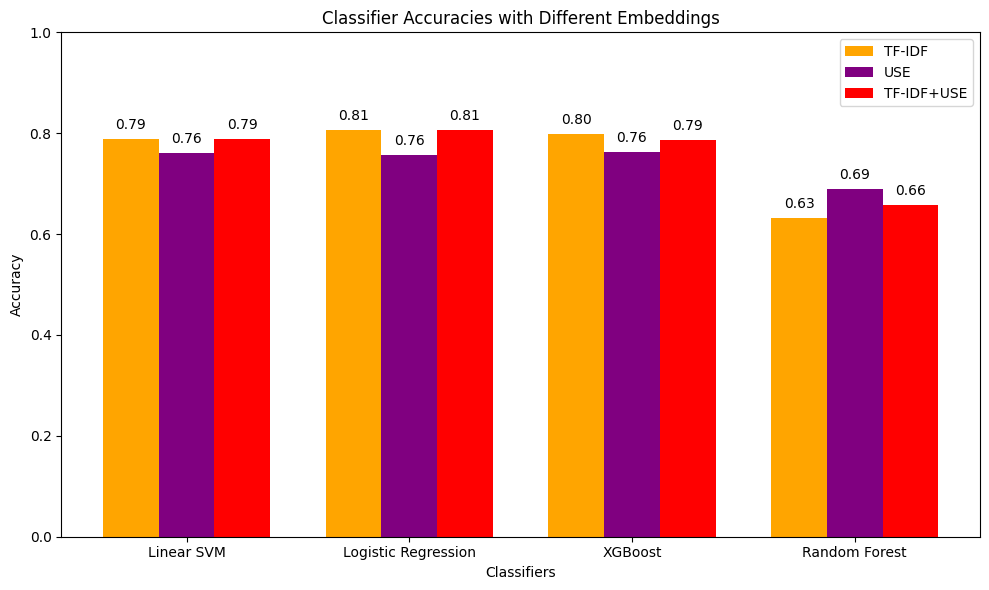

In [100]:
# Define the classifiers and their corresponding accuracies
classifiers = ["Linear SVM", "Logistic Regression", "XGBoost", "Random Forest"]
tfidf_accuracies = [accuracy_svm, accuracy_lr, accuracy_xgboost, accuracy_rfc]  # Replace with actual accuracy values
use_accuracies = [accuracy_svm_use, accuracy_lr_use, accuracy_xgboost_use, accuracy_rfc_use]  # Replace with actual accuracy values
tfidf_use_accuracies = [accuracy_svm_tfidf_use, accuracy_lr_tfidf_use, accuracy_xgb_tfidf_use, accuracy_rfc_tfidf_use]  # Replace with actual accuracy values

# Create an index for the x-axis
x = np.arange(len(classifiers))

# Set the width of the bars
bar_width = 0.25

# Create a grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, tfidf_accuracies, bar_width, label='TF-IDF', color='orange')
plt.bar(x, use_accuracies, bar_width, label='USE', color='purple')
plt.bar(x + bar_width, tfidf_use_accuracies, bar_width, label='TF-IDF+USE', color='red')

# Set labels, title, and legend
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracies with Different Embeddings')
plt.xticks(x, classifiers)
plt.ylim(0, 1.0)
plt.legend()

# Add accuracy values on top of the bars
for i in range(len(classifiers)):
    plt.text(x[i] - bar_width, tfidf_accuracies[i] + 0.02, f"{tfidf_accuracies[i]:.2f}", ha='center')
    plt.text(x[i], use_accuracies[i] + 0.02, f"{use_accuracies[i]:.2f}", ha='center')
    plt.text(x[i] + bar_width, tfidf_use_accuracies[i] + 0.02, f"{tfidf_use_accuracies[i]:.2f}", ha='center')


# Display the plot
plt.tight_layout()
plt.show()


#### Conclusion: If you see above visualization, as compared to TF-IDF embedding, USE as well as TF-IDF+USE embeddings works better for sentiment analysis on IMDB dataset with different classifiers

Reference:
https://github.com/FarhanaTeli/Sentiment_Analysis_IMDB

https://github.com/Wittline/tf-idf